In [1]:
# Import needed built-in modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import sys

from pathlib import Path
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.convolution import Gaussian1DKernel, convolve

# Import modules from third-party sources
workdir = Path.cwd() / '../'
sys.path.append(str(workdir / 'lib'))
# sys.path.append('/usr/local/lib/python3.7/site-packages')
# sys.path.append('/Users/kmohamad/Library/Python/3.7/lib/python/site-packages')

from py_specrebin import rebinspec
from smooth_gauss import gauss_ivar

# Documentation can be found on https://pypi.org/project/ppxf/
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util

In [2]:
CONST = {'C':299792.458}

In [3]:
#-----------------------#
#   Class Definitions   #
#-----------------------#
       
class Spectrum:
    
    def __init__(self, wavelength, flux, ivar):
        
        flux[flux < 0] = 0
        noise = np.nan_to_num(np.sqrt(1/ivar))
        noise[noise > 1e+7] = 999.
        noise[noise < 1e-7] = 0
        
        self.wavelength = wavelength
        self.flux = flux
        self.ivar = ivar
        self.noise = noise  
        
    @classmethod
    def from_HDU(cls, hdu):
        return cls(hdu['LAMBDA'][0], hdu['SPEC'][0], hdu['IVAR'][0])
    
    @classmethod
    def with_noise(cls, wavelength, flux, noise):
        a = cls(wavelength, flux, np.array([1]))
        a.noise = noise
        a.ivar = 1 / noise**2
        
        return a

In [4]:
def read_HDU(hdu):
    
    try:
        if 'Bxspf-B' in hdu and 'Bxspf-R' in hdu:
            blue_name = 'Bxspf-B'
            red_name = 'Bxspf-R'
            
        else:
            blue_name = 'Horne-B'
            red_name = 'Horne-R'
            
        wavelength_b = f[blue_name].data['LAMBDA'][0]
        wavelength_r = f[red_name].data['LAMBDA'][0]

        flux_b = f[blue_name].data['SPEC'][0]
        flux_r = f[red_name].data['SPEC'][0]

        ivar_b = f[blue_name].data['IVAR'][0]
        ivar_r = f[red_name].data['IVAR'][0]
        
        wb = np.arange(
            np.min(wavelength_b), 
            np.max(wavelength_b), 
            wavelength_b[1] - wavelength_b[0]
        )
        
        wr = np.arange(
            np.min(wavelength_r), 
            np.max(wavelength_r), 
            wavelength_b[1] - wavelength_b[0]
        )

    except KeyError:
        return None
    except ValueError:
        return None
    
    flux_b, ivar_b = np.nan_to_num(rebinspec(wavelength_b, flux_b, wb, ivar = ivar_b))
    flux_r, ivar_r = np.nan_to_num(rebinspec(wavelength_r, flux_r, wr, ivar = ivar_r))
    
    flux = np.append(flux_b, flux_r)
    w = np.append(wb, wr)
    ivar = np.append(ivar_b, ivar_r)
    
    return Spectrum(w, flux, ivar)


In [5]:
def ppxf_run(log_spec, param):
    
    if not np.sum(log_spec.flux) > 0:
        return 0, 0
    
    ppxf_result = ppxf(
        param['TEMPLATE_FLUX'], 
        log_spec.flux, 
        param['NOISE'], 
        param['VELSCALE'], 
        param['START'], 
        goodpixels = param['GOOD_PIXELS'], 
        plot = param['PLOT'], 
        moments = 2, 
        degree = 12, 
        vsyst = param['DV'], 
        clean = False, 
        lam = np.exp(log_spec.wavelength), 
        quiet = 1
    )

    return ppxf_result.sol[0], ppxf_result.sol[1]

In [1]:
# Import needed built-in modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import glob
import sys

from pathlib import Path
from astropy.io import fits, ascii
from astropy.convolution import Gaussian1DKernel, convolve

# Import modules from third-party sources
workdir = Path.cwd() / '../'
sys.path.append(str(workdir / 'lib'))
# sys.path.append('/usr/local/lib/python3.7/site-packages')

from py_specrebin import rebinspec
from smooth_gauss import gauss_ivar

# Documentation can be found on https://pypi.org/project/ppxf/
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util

CONST = {
    'C':299792.458
}

In [9]:
# Initializations

template_files = glob.glob(
    str(workdir / 'lib' / 'ppxf' / 'DEIMOS_600' / 'template*.fits')
)

head = fits.open(template_files[0])[0].header
template_wavelength = head['CRVAL1'] + head['CDELT1']*np.arange(head['NAXIS1'])
template_wavelength_range = (template_wavelength[0], template_wavelength[-1])

linear_template_fluxes = np.zeros((len(template_files), len(template_wavelength)))

for ind, file in enumerate(template_files):
    linear_template_fluxes[ind, :] = fits.open(file)[0].data[0]

    
    
config_file = ascii.read(workdir / 'Kadri' / 'DEIMOS_VDGC_copy.conf').to_pandas()
config_file.columns = map(str.upper, config_file.columns)
config_file = config_file.set_index('OBJECT')


poly = {}
poly['COSMOS'] = np.load(workdir / 'Kadri' / 'galaxy_LSF_output/COSMOS.deltaLambdaFit.npy')
poly['EGS'] = np.load(workdir / 'Kadri' / 'galaxy_LSF_output/EGS.deltaLambdaFit.npy')
poly['GOODSN'] = np.load(workdir / 'Kadri' / 'galaxy_LSF_output/GOODSN.deltaLambdaFit.npy')

aband_poly = np.poly1d(
    (poly['COSMOS'] + poly['EGS'] + poly['GOODSN'])[:, 0]/3
)


In [6]:
fin = open('vdgc_dataframe_w_spectra.obj', 'rb')
data = pickle.load(fin)

In [7]:
none_index = [ind for ind, x in enumerate(data['FILE_INFO']) if x is None ]

clean_data = data.drop(data.index[none_index], axis = 0)

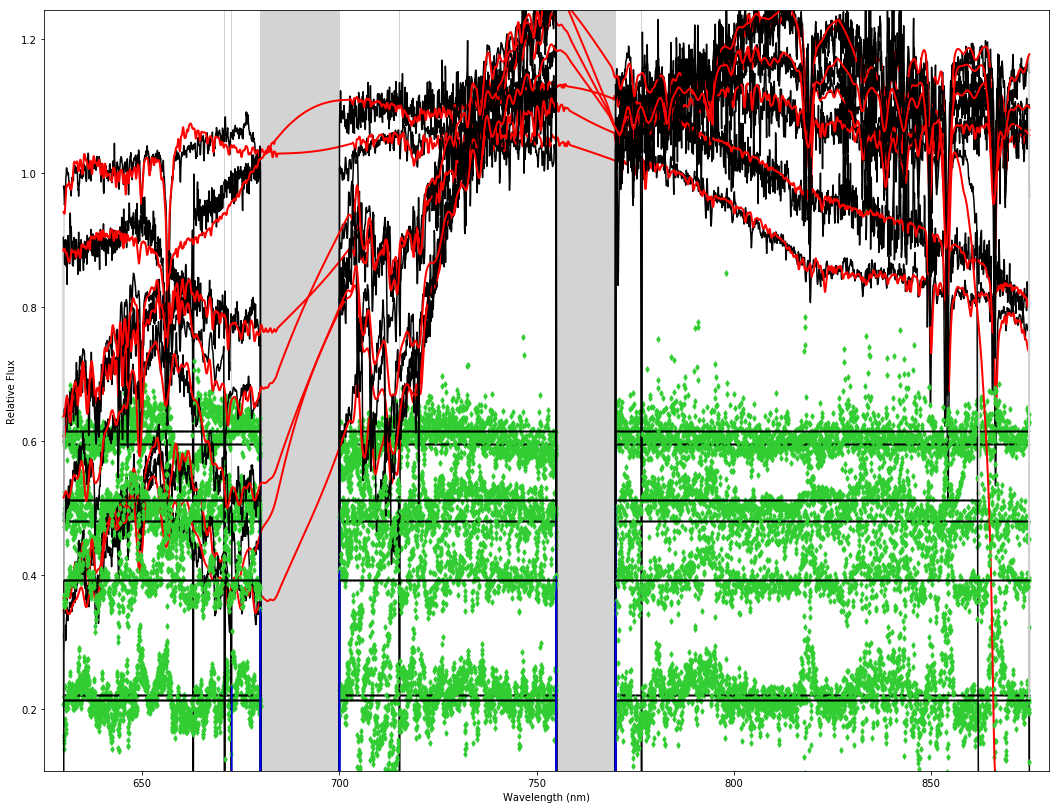

In [40]:
plt.figure(figsize = (18,14))

for index, conf_row in config_file.head(n=7).iterrows():
    
    row = clean_data.loc[index + '.gz']
        
    redshift = row['VOBS'] / CONST['C']
    ppxf_lambda_range = (conf_row['LAMBMIN'], conf_row['LAMBMAX'])
    std_dev = conf_row['STDDEV']
        
    spec = row['FILE_INFO']
    file_lambda_range = (spec.wavelength[0], spec.wavelength[-1])
    file_delta_lambda = spec.wavelength[1] - spec.wavelength[0]
    
    ppxf_lambda_mask = (
        (spec.wavelength >= ppxf_lambda_range[0]) &\
        (spec.wavelength <= ppxf_lambda_range[1])
    )

    spec.wavelength = spec.wavelength[ppxf_lambda_mask]
    spec.flux = spec.flux[ppxf_lambda_mask]
    spec.ivar = spec.ivar[ppxf_lambda_mask]
    spec.noise = spec.noise[ppxf_lambda_mask]
    
    aband_lambda_correction = (
        (row['ABANDCOR']*7600*aband_poly(spec.wavelength))
        / (CONST['C']*aband_poly(7600))
    )

    flux, ivar = np.nan_to_num(
        rebinspec(
            spec.wavelength - aband_lambda_correction, 
            spec.flux, 
            spec.wavelength, 
            ivar = spec.ivar
        )
    )
    
    linear_spec = Spectrum(spec.wavelength, flux, ivar)
    
    frac = linear_spec.wavelength[1] / linear_spec.wavelength[0]
    velscale = np.log(frac) * CONST['C']
    
    log_flux, log_wavelength, log_velscale = np.nan_to_num(util.log_rebin(
            file_lambda_range, linear_spec.flux, velscale = velscale
    ))
    
    log_noise, _, _ = np.nan_to_num(util.log_rebin(
            file_lambda_range, linear_spec.noise, velscale = velscale
    ))
    
    log_noise /= np.median(log_flux[log_flux > 0])
    log_flux /= np.median(log_flux[log_flux > 0])
    ppxf_noise = np.full_like(log_flux, 0.0166) 
    
    a_b_band = (
        ((log_wavelength>np.log(6800)) & (log_wavelength<np.log(7000))) |
        ((log_wavelength>np.log(7550)) & (log_wavelength<np.log(7700))) 
    )
    
    log_flux[a_b_band] = 0.
    
    log_spec = Spectrum.with_noise(log_wavelength, log_flux, log_noise)
    
    good_pixels = np.arange(len(log_wavelength))
    good_pixels = good_pixels[log_flux != 0]
    
    num_pixels = len(util.log_rebin(
        template_wavelength_range, linear_template_fluxes[0], velscale = velscale)[0])

    log_template_fluxes = np.empty((num_pixels, len(template_files)))
    
    for ind, temp_row in enumerate(linear_template_fluxes):
        log_template_fluxes[:, ind], _, _ = util.log_rebin(
            template_wavelength_range,
            temp_row,
            velscale = velscale
        )
        
    log_template_fluxes = np.nan_to_num(log_template_fluxes)
    log_template_fluxes[log_template_fluxes > 1e+7] = 999.
    log_template_fluxes[log_template_fluxes < 1e-7] = 0.
    
    velocity = np.log(1 + conf_row['VEL']/CONST['C'])
    
    params = {
        'TEMPLATE_FLUX': log_template_fluxes,
        'NOISE': ppxf_noise,
        'VELSCALE': velscale,
        'START': [velocity, 3*velscale],
        'GOOD_PIXELS': good_pixels,
        'PLOT': True,
        'DV': np.log(template_wavelength[0]/spec.wavelength[0]) * CONST['C']
    }
    
    radial_vel, sigma = ppxf_run(log_spec, params)

In [29]:
num_pixels = len(util.log_rebin(
    template_wavelength_range, linear_template_fluxes[0], velscale = velscale)[0])

log_template_fluxes = np.empty((num_pixels, len(template_files)))

for ind, temp_row in enumerate(linear_template_fluxes):
    log_template_fluxes[:, ind], _, _ = util.log_rebin(
        template_wavelength_range,
        temp_row,
        velscale = velscale
    )

log_template_fluxes = np.nan_to_num(log_template_fluxes)
log_template_fluxes[log_template_fluxes > 1e+7] = 999.
log_template_fluxes[log_template_fluxes < 1e-7] = 0.

velocity = np.log(1 + conf_row['VEL']/CONST['C'])

params = {
    'TEMPLATE_FLUX': log_template_fluxes,
    'NOISE': ppxf_noise,
    'VELSCALE': velscale,
    'START': [velocity, 3*velscale],
    'GOOD_PIXELS': good_pixels,
    'PLOT': True,
    'DV': np.log(template_wavelength[0]/spec.wavelength[0]) * CONST['C']
}

radial_vel, sigma = ppxf_run(log_spec, params)

AssertionError: TEMPLATES length cannot be smaller than GALAXY

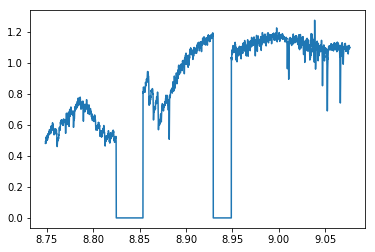

In [42]:
plt.plot(log_spec.wavelength, log_flux)

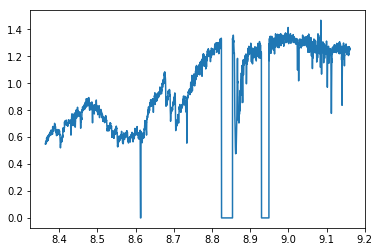

In [39]:
plt.plot(log_spec.wavelength, log_spec.flux)

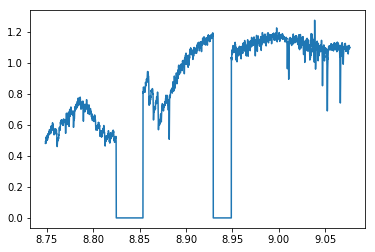

In [41]:
plt.plot(log_spec.wavelength, log_spec.flux)

In [38]:
np.shape(log_template_fluxes)

(8160, 17)

In [37]:
np.shape(log_spec.flux)

(8285,)

In [33]:
np.shape(log_spec.flux)

(3443,)

In [34]:
np.shape(log_template_fluxes)

(8226, 17)

In [16]:
#RUNNING PPXF
vel=c*np.log(1+z)
start=[vel,3*velscale]
dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s


pp=ppxf(templates, flux, ppxf_noise, velscale, start,
        goodpixels=goodpixels, plot=True, moments=2, #sky=sky,
        degree=12, vsyst=dv, clean=False,lam=np.exp(logLam), quiet=1)

print(conf['Object'][i],'Vel=',round(pp.sol[0],2),' sigma=',round(pp.sol[1],2))


NameError: name 'c' is not defined

In [ ]:
        flux_nw, ivar_nw=rebinspec(lam_gal2, flux, lam_gal, ivar=1/(noise**2))
    
        flux=np.nan_to_num(flux_nw)#change nan to 0
        ivar=np.nan_to_num(ivar_nw)
        noise=1/np.sqrt(ivar)
        
        #log rebin the object
        lamRange_gal=[np.min(lam_gal),np.max(lam_gal)]
        frac=lam_gal[1]/lam_gal[0]
        velscale=np.log(frac)*c #resolution in km/s (deltaLambda/lambda)
        lin_lam=lam_gal
        lin_flux=flux
        lin_noise=noise
       
        logflux, logLam, kk=util.log_rebin(lamRange_gal, flux, velscale=velscale)
        lognoise=util.log_rebin(lamRange_gal, noise, velscale=velscale)[0]
       
        logflux[(logflux!=logflux)]=0.
        
        flux = logflux/np.median(logflux[(logflux>0)])
        noise = lognoise/np.median(logflux[(logflux>0)])
        ppxf_noise = np.full_like(flux, 0.0166) #assume constant noise (we'll use the real noise in the MC only)

        
        
        #remove the a-band and b-band by putting them to flux=0: (this is not needed here because the templates don't have these bands in them)
        aband=np.where((logLam>np.log(7550))&(logLam<np.log(7700)))[0] #lambda affected
        bband=np.where((logLam>np.log(6800))&(logLam<np.log(7000)))[0] #b-band 6800-7000, earlier beginning to remove the cup shape
        flux[aband]=0.
        flux[bband]=0.

        #goodpixels=util.determine_goodpixels(logLam, lamRange, z) #only when you need to remove emission lines
        goodpixels=np.array(range(len(logLam)))

        #remove the chip gap and other pixels without flux:
        remove=np.where(flux==0)[0] 
        index=[]

        for j in range(len(remove)):
            for k in range(len(goodpixels)):
                if remove[j]==goodpixels[k]:
                    index.append(k)

        goodpixels=np.delete(goodpixels,index)
        

In [96]:
files = glob.glob(str(workdir / 'lib' / 'ppxf' / 'DEIMOS_600' / 'template*.fits'))

f = fits.open(files[0])

flux = f[0].data[0]
head = f[0].header
temp_lambda = head['CRVAL1'] + head['CDELT1'] * np.arange(head['NAXIS1'])

velscale = np.log(temp_lambda[1]/temp_lambda[0]) * CONSTANT['C']

tlamb = util.log_rebin(
        [temp_lambda[0], temp_lambda[-1]], f[0].data[0], velscale = velscale)[1]

temp_flux = np.zeros((len(tlamb), len(files)))

for ii, file in enumerate(files):
    f = fits.open(file)
    temp_flux[:, ii] = util.log_rebin(
        [temp_lambda[0], temp_lambda[-1]],
        f[0].data[0],
        velscale = velscale
    )[0]
    
temp_flux[(temp_flux != temp_flux)]=0.
temp_flux[(temp_flux > 10e6)] = 999.
temp_flux[(temp_flux < 10e-6)] = 0.

In [97]:
conf = ascii.read(workdir / 'Kadri' / 'DEIMOS_VDGC_copy.conf')

DONE


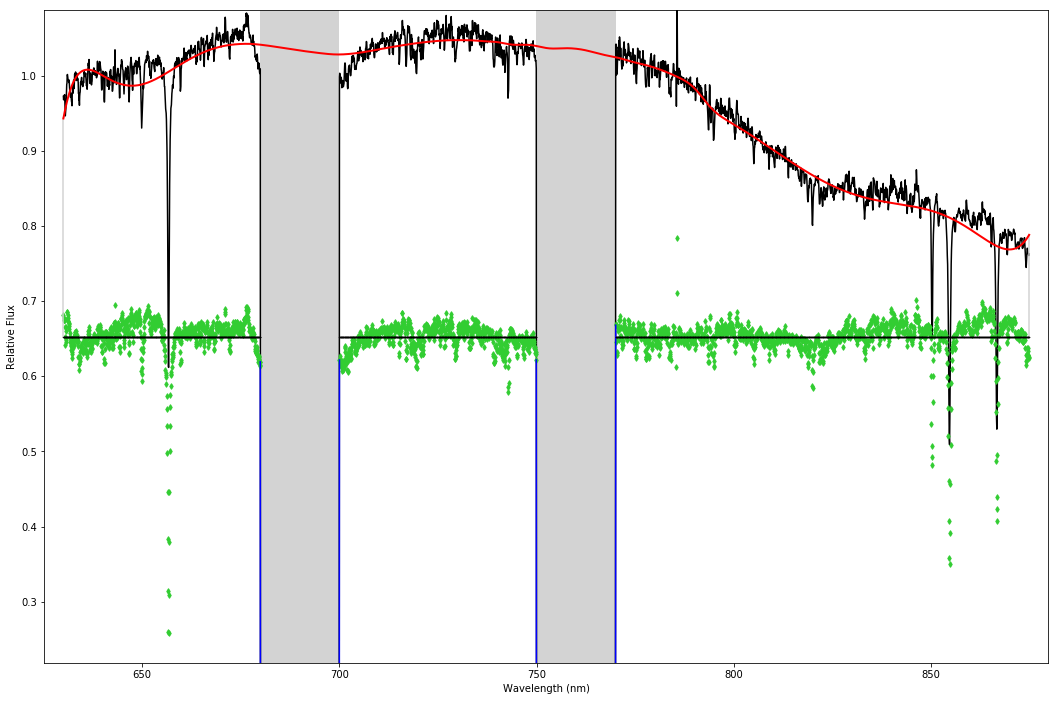

In [99]:
plt.figure(figsize=(18,12))

for conf_row in conf:
    
    try:
        row = data.loc[conf_row['Object'] + '.gz']
        index = row.name
    except KeyError:
        print(conf_row['Object'])
        continue
    
    file_path = workdir / 'spectra' / index
    
    if file_path.exists():
        f = fits.open(file_path)
    elif Path(str(file_path)[:-3]).exists():
        f = fits.open(Path(str(file_path)[:-3]))
    else:
        print(index)
        raise FileNotFoundError
        
    hdu = HDU_Reader(f)
    
    # Rebinning in linear scale
    spec = Spectrum(1, 1, 1)
    spec.wavelength = hdu.wavelength
    hdu.wavelength += (7600 * row['ABANDCOR'] * aband_poly(hdu.wavelength) 
                        / (aband_poly(7600) * CONSTANT['C']))
    
    spec.flux, spec.ivar = np.nan_to_num(
        rebinspec(hdu.wavelength, hdu.flux, spec.wavelength, ivar = hdu.ivar)
    )
    
    lamb_mask = ~(
        (spec.wavelength<conf_row['LambMin']) | (spec.wavelength>conf_row['LambMax'])
    )
    
    spec.flux = spec.flux[lamb_mask]
    spec.wavelength = spec.wavelength[lamb_mask]
    spec.ivar = spec.ivar[lamb_mask]
    
    spec.noise = np.nan_to_num(np.sqrt(1/spec.ivar))
    spec.flux[spec.flux < 10e-6] = 0
    spec.noise[spec.noise < 10e-6] = 0
    
    # Rebinning in log scale
    wavelength_range = (spec.wavelength[0], spec.wavelength[-1])  
    velscale = np.log(spec.wavelength[1]/spec.wavelength[0]) * CONSTANT['C']
    
    flux, wavelength, velscale = np.nan_to_num(
        util.log_rebin(wavelength_range, spec.flux, velscale = velscale)
    )
    
    noise = np.nan_to_num(
        util.log_rebin(wavelength_range, spec.noise, velscale=velscale)[0]
    )
    
    a_b_band = (
        ((wavelength>np.log(6800)) & (wavelength<np.log(7000)))
        | ((wavelength>np.log(7500)) & (wavelength<np.log(7700)))
    )
    
    flux[(flux < 0) | a_b_band] = 0
    ppxf_noise = np.full_like(flux, 0.0166) 
    # noise = np.nan_to_num(1/np.sqrt(data.ivar))
    noise[noise > 1e+6] = 999
    noise[noise < 1e-6] = 0
    
    log_spec = Spectrum(
        wavelength,
        flux / np.median(flux[flux > 0]),
        np.nan_to_num(1 / (noise / np.median(flux[flux > 0])**2)),
    )
    
    # Why use uniform noise on the ppxf function, and not the real one
    ppxf_noise = np.full_like(flux, 0.0166)
    
    good_pixels = np.arange(len(log_spec.wavelength))
    good_pixels = np.delete(good_pixels, np.where(log_spec.flux == 0))
    
    aband_params = {}
    aband_params['GOOD_PIXELS'] = good_pixels
    aband_params['VELSCALE'] = velscale
    aband_params['VEL'] = CONSTANT['C'] * np.log(1 + row['VOBS']/CONSTANT['C'])
    aband_params['START'] = [aband_params['VEL'], 3*velscale]
    aband_params['TEMP_FLUX'] = temp_flux
    aband_params['DV'] = np.log(temp_lambda[0]/spec.wavelength[0]) * CONSTANT['C']
    aband_params['NOISE'] = ppxf_noise

    radial_vel, sigma = ppxf_run(log_spec, aband_params)
    
    # Perform Markov-Chain Monte Carlo simulations
    num_iter = 100
    mcmc = {'VEL':np.zeros(num_iter), 'SIGMA':np.zeros(num_iter)}
    aband_params['NOISE'] = log_spec.noise

    for ii in range(num_iter):
        mcmc_flux = np.random.normal(log_spec.flux, log_spec.noise)
        
        mcmc_spec = Spectrum(
            wavelength,
            mcmc_flux / np.median(mcmc_flux[mcmc_flux > 0]),
            log_spec.ivar
        )
        
        mcmc['VEL'][ii], mcmc['SIGMA'][ii] = ppxf_run(mcmc_spec, aband_params, False)
    
    print('DONE')
    break

Median velocity: 26.46 Median sigma: 81.95
Velocity errors: 2.85 4.08
Sigma errors: 8.71 5.16


(array([ 1.,  2.,  9., 27., 22., 15., 17.,  5.,  1.,  1.]),
 array([16.97059738, 19.089544  , 21.20849063, 23.32743725, 25.44638387,
        27.56533049, 29.68427712, 31.80322374, 33.92217036, 36.04111698,
        38.16006361]),
 <a list of 10 Patch objects>)

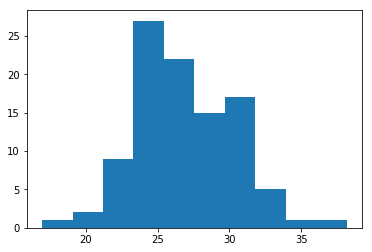

In [100]:
v_MC = mcmc['VEL']
s_MC = mcmc['SIGMA']

print('Median velocity:', round(np.median(v_MC),2), 'Median sigma:', round(np.median(s_MC),2))
print('Velocity errors:', round(np.median(v_MC)-np.percentile(v_MC,16),2), round(np.percentile(v_MC,84)-np.median(v_MC),2))
print('Sigma errors:', round(np.median(s_MC)-np.percentile(s_MC,16),2), round(np.percentile(s_MC,84)-np.median(s_MC),2))

plt.hist(mcmc['VEL'], bins=10)

In [ ]:
vel=c*np.log(1+z)
start=[vel,3*velscale]
dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s


pp=ppxf(templates, flux, ppxf_noise, velscale, start,
        goodpixels = goodpixels, plot = True, moments = 2, #sky=sky,
        degree = 12, vsyst = dv, clean = False, lam = np.exp(logLam), quiet = 1)

print(conf['Object'][i],'Vel=',round(pp.sol[0],2),' sigma=',round(pp.sol[1],2))

#-----------------------------------------------------
#MC SIMULATIONS:

num_iter = 100
MC = {'VEL':np.zeros(num_iter), 'SIGMA':np.zeros(num_iter)}
params = {'INIT':0}

for ii in range(num_iter):
    mc_flux = np.random.normal(data.spectra, abs(np.nan_to_num(np.sqrt(1/data.ivar))))
    MC['VEL'][ii], MC['SIGMA'][ii] = ppxf_run(mc_flux, params)


print('Median velocity:', round(np.median(v_MC),2), 'Median sigma:', round(np.median(s_MC),2))
print('Velocity errors:', round(np.median(v_MC)-np.percentile(v_MC,16),2), round(np.percentile(v_MC,84)-np.median(v_MC),2))
print('Sigma errors:', round(np.median(s_MC)-np.percentile(s_MC,16),2), round(np.percentile(s_MC,84)-np.median(s_MC),2))

noise[aband]=0.
noise[bband]=0.
print('S/N per pixel:', round(np.median(flux)/np.median(noise),2))

#-----------------------------------------------------
#SAVE THE RESULTS IN AN ASCII FILE

f=open('../ppxf/results/'+conf['Object'][i]+'.dat','w')
f.write('#S/N  V  V_MC  Vpe  Vne  S  S_MC  Spe  Sne  Aband  Aband_MC  Aband_pe  Aband_ne \n')
f.write( str(round(np.median(flux)/np.median(noise),2))+'  '+str(round(pp.sol[0],2))+'  '+str(round(np.median(v_MC),2))+'  '+str(round(np.percentile(v_MC,84)-np.median(v_MC),2))+'  '+str(round(np.median(v_MC)-np.percentile(v_MC,16),2))+'  '+str(round(pp.sol[1],2))+'  '+str(round(np.median(s_MC),2))+'  '+str(round(np.percentile(s_MC,84)-np.median(s_MC)))+'  '+str(round(np.median(s_MC)-np.percentile(s_MC,16),2))+'  '+str(round(v_aband,2))+'  '+str(round(np.median(v_aband_MC),2))+'  '+str(round(np.percentile(v_aband_MC,84)-np.median(v_aband_MC),2))+'  '+str(round(np.median(v_aband_MC)-np.percentile(v_aband_MC,16),2))+'\n')
f.close()

In [ ]:
f[0].data

In [ ]:
#-----------------------------------------------------
#A-BAND CORRECTION

#keep only the parameter values (drop the uncertainties)
deltaLambPolyVals = np.load('galaxy_LSF_output/COSMOS.deltaLambdaFit.npy')[:,0]
deltaLambFunc = np.poly1d(deltaLambPolyVals) #this is the LSF 
lsf = deltaLambFunc(lam_gal) #returns the value of the parabola at each wavelength
delta_lamb=v_aband*7600*lsf/c/deltaLambFunc(7600) #we use 7600 because it's the wavelength for the Aband, where we calculate the correction
lam_gal2=lam_gal+delta_lamb #Now, the step between consequtive pixels is not constant
flux2=flux

flux_nw, ivar_nw=rebinspec(lam_gal2, flux, lam_gal, ivar=1/(noise**2))

flux=np.nan_to_num(flux_nw)#change nan to 0
ivar=np.nan_to_num(ivar_nw)
sky=np.nan_to_num(sky_nw)
noise=1/np.sqrt(ivar)

#remove NaN, inf
noise[(noise!=noise)]=0.
noise[(noise>10e6)]=999.
noise[(noise<10e-6)]=0.

#remove negative values of flux
flux[(flux<0)]=0.
sky[(sky<0)]=0.

#log rebin the object
lamRange_gal=[np.min(lam_gal),np.max(lam_gal)]
frac=lam_gal[1]/lam_gal[0]
velscale=np.log(frac)*c #resolution in km/s (deltaLambda/lambda)
lin_lam=lam_gal
lin_flux=flux
lin_noise=noise

logflux, logLam, kk=util.log_rebin(lamRange_gal, flux, velscale=velscale)
lognoise=util.log_rebin(lamRange_gal, noise, velscale=velscale)[0]
logsky=util.log_rebin(lamRange_gal, sky, velscale=velscale)[0]
logflux[(logflux!=logflux)]=0.
flux=logflux/np.median(logflux[(logflux>0)])
noise=lognoise/np.median(logflux[(logflux>0)])
ppxf_noise=np.full_like(flux, 0.0166) #assume constant noise (we'll use the real noise in the MC only)
logsky[(logsky!=logsky)]=0.
sky=logsky/np.median(logsky[(logsky>0)])

#remove the a-band and b-band by putting them to flux=0: (this is not needed here because the templates don't have these bands in them)
aband=np.where((logLam>np.log(7550))&(logLam<np.log(7700)))[0] #lambda affected
bband=np.where((logLam>np.log(6800))&(logLam<np.log(7000)))[0] #b-band 6800-7000, earlier beginning to remove the cup shape
flux[aband]=0.
flux[bband]=0.
sky[aband]=0.
sky[bband]=0.

#goodpixels=util.determine_goodpixels(logLam, lamRange, z) #only when you need to remove emission lines
goodpixels=np.array(range(len(logLam)))

#remove the chip gap and other pixels without flux:
remove=np.where(flux==0)[0] 
index=[]

for j in range(len(remove)):
    for k in range(len(goodpixels)):
        if remove[j]==goodpixels[k]:
            index.append(k)

goodpixels=np.delete(goodpixels,index)

#rebin in log and save the templates together
flux_temp0=fits.open(templates_names[0])[0].data
flux_temp0=flux_temp0[0]
loglam=util.log_rebin(lamRange_temp, flux_temp0, velscale=velscale)[0]
templates=np.empty((len(loglam), ntemp))

for j in range(ntemp):
    flux_temp=fits.open(templates_names[j])[0].data
    newflux=util.log_rebin(lamRange_temp, flux_temp[0], velscale=velscale)[0]
    templates[:,j]=newflux

#remove NaN, inf
templates[(templates!=templates)]=0.
templates[(templates>10e6)]=999.
templates[(templates<10e-6)]=0.

#-----------------------------------------------------
#RUNNING PPXF


vel=c*np.log(1+z)
start=[vel,3*velscale]
dv = np.log(lam_temp[0]/lam_gal[0])*c    # km/s


pp=ppxf(templates, flux, ppxf_noise, velscale, start,
        goodpixels=goodpixels, plot=True, moments=2, #sky=sky,
        degree=12, vsyst=dv, clean=False,lam=np.exp(logLam), quiet=1)

print(conf['Object'][i],'Vel=',round(pp.sol[0],2),' sigma=',round(pp.sol[1],2))

#-----------------------------------------------------
#MC SIMULATIONS:

num_iter = 100
MC = {'VEL':np.zeros(num_iter), 'SIGMA':np.zeros(num_iter)}
params = {'INIT':0}

for ii in range(num_iter):
    mc_flux = np.random.normal(data.spectra, abs(np.nan_to_num(np.sqrt(1/data.ivar))))
    MC['VEL'][ii], MC['SIGMA'][ii] = ppxf_run(mc_flux, params)


print('Median velocity:', round(np.median(v_MC),2), 'Median sigma:', round(np.median(s_MC),2))
print('Velocity errors:', round(np.median(v_MC)-np.percentile(v_MC,16),2), round(np.percentile(v_MC,84)-np.median(v_MC),2))
print('Sigma errors:', round(np.median(s_MC)-np.percentile(s_MC,16),2), round(np.percentile(s_MC,84)-np.median(s_MC),2))

noise[aband]=0.
noise[bband]=0.
print('S/N per pixel:', round(np.median(flux)/np.median(noise),2))

#-----------------------------------------------------
#SAVE THE RESULTS IN AN ASCII FILE

f=open('../ppxf/results/'+conf['Object'][i]+'.dat','w')
f.write('#S/N  V  V_MC  Vpe  Vne  S  S_MC  Spe  Sne  Aband  Aband_MC  Aband_pe  Aband_ne \n')
f.write( str(round(np.median(flux)/np.median(noise),2))+'  '+str(round(pp.sol[0],2))+'  '+str(round(np.median(v_MC),2))+'  '+str(round(np.percentile(v_MC,84)-np.median(v_MC),2))+'  '+str(round(np.median(v_MC)-np.percentile(v_MC,16),2))+'  '+str(round(pp.sol[1],2))+'  '+str(round(np.median(s_MC),2))+'  '+str(round(np.percentile(s_MC,84)-np.median(s_MC)))+'  '+str(round(np.median(s_MC)-np.percentile(s_MC,16),2))+'  '+str(round(v_aband,2))+'  '+str(round(np.median(v_aband_MC),2))+'  '+str(round(np.percentile(v_aband_MC,84)-np.median(v_aband_MC),2))+'  '+str(round(np.median(v_aband_MC)-np.percentile(v_aband_MC,16),2))+'\n')
f.close()

In [ ]:
help(util.log_rebin)

In [ ]:

        
        #a-band template:
        flux_aband_temp=fits.open(aband_temp_name[0])[0].data
        aband_temp=util.log_rebin(lamRange_temp, flux_aband_temp[0], velscale=aband_velscale)[0]

        #remove NaN, inf
        aband_temp[(aband_temp!=aband_temp)]=0.
        aband_temp[(aband_temp>10e6)]=999.
        aband_temp[(aband_temp<10e-6)]=0.
        
        #-----------------------------------------------------
        #log rebin the a-band region of the object
        lin_aband_lam=aband_lam
        lin_aband_flux=aband_flux
        lin_aband_noise=aband_noise
        
        logaband_flux, aband_logLam, kkk=util.log_rebin(lamRange_aband, aband_flux, velscale=aband_velscale)
        logaband_noise=util.log_rebin(lamRange_aband, aband_noise, velscale=aband_velscale)[0]
        aband_flux=logaband_flux/np.median(logaband_flux)
        aband_noise=logaband_noise/np.median(logaband_flux)
        ppxf_aband_noise=np.full_like(aband_flux, 0.0166) #assume constant noise (we'll use the real noise in the MC only)
        aband_flux[(aband_flux!=aband_flux)]=0.
        
        #put the region in between the a and b bands to flux=0:
        btw=np.where((aband_logLam>np.log(7000))&(aband_logLam<np.log(7500)))
        aband_flux[btw]=0
        
        #goodpixels=util.determine_goodpixels(logLam, lamRange, z) #only when you need to remove emission lines
        aband_goodpixels=np.array(range(len(aband_logLam)))
        
        #remove those pixels without flux from the a band flux:
        remove=np.where(aband_flux==0)[0] 
        index=[]

        for j in range(len(remove)):
            for k in range(len(aband_goodpixels)):
                if remove[j]==aband_goodpixels[k]:
                    index.append(k)

        aband_goodpixels=np.delete(aband_goodpixels,index)
        
        #-----------------------------------------------------
        #A-BAND MEASUREMENT:
        vel=0.
        start=[vel,3*aband_velscale]
        dv = np.log(lam_temp[0]/aband_lam[0])*c    # km/s
        t=clock()
        
        if sum(aband_flux)>0.:
            aband_pp=ppxf(aband_temp, aband_flux, aband_noise, aband_velscale, start,
                    goodpixels=aband_goodpixels, plot=True, moments=2,
                    degree=12, vsyst=dv, clean=False,lam=np.exp(aband_logLam), quiet=1)

            v_aband=aband_pp.sol[0]
            s_aband=aband_pp.sol[1]
        else:
            v_aband=0.
            s_aband=0.
        print(conf['Object'][i],'Vel=',round(v_aband,2),' sigma=',round(s_aband,2))
        #-----------------------------------------------------
        #MC SIMULATIONS:
        nsimul=100
        v_aband_MC=np.zeros((nsimul))
        s_aband_MC=np.zeros((nsimul))
        if sum(aband_flux)>0.: #there may be some slits where the blue chip crassed and we don't have flux for the a band
            start_MC=aband_pp.sol
            for j in range(nsimul):
                print(conf['Object'][i],'A-band Monte Carlo:',j)
                flux_aband_MC=np.zeros((len(aband_flux)))
                for k in range(len(aband_flux)):
                    #flux_aband_MC[k]=aband_flux[k]+np.random.normal(aband_flux[k],aband_noise[k])
                    flux_aband_MC[k]=aband_flux[k]+np.random.normal(aband_flux[k],abs(aband_noise[k]))

                pp_aband_MC=ppxf(aband_temp, flux_aband_MC/np.median(flux_aband_MC), ppxf_aband_noise, aband_velscale, start_MC,
                    goodpixels=aband_goodpixels, plot=True, moments=2,
                    degree=12, vsyst=dv, clean=False, lam=np.exp(aband_logLam), quiet=1)
                v_aband_MC[j]=pp_aband_MC.sol[0]
                s_aband_MC[j]=pp_aband_MC.sol[1]
        else:
            v_aband_MC=0.
            s_aband_MC=0.
            
        print('Median velocity:', round(np.median(v_aband_MC),2), 'Median sigma:', round(np.median(s_aband_MC),2))
        print('Velocity errors:', round(np.median(v_aband_MC)-np.percentile(v_aband_MC,16),2), round(np.percentile(v_aband_MC,84)-np.median(v_aband_MC),2))
        print('Sigma errors:', round(np.median(s_aband_MC)-np.percentile(s_aband_MC,16),2), round(np.percentile(s_aband_MC,84)-np.median(s_aband_MC),2))
        print('Elapsed time in PPXF: %.2f s' % (clock() - t))

        #-----------------------------------------------------
        #A-BAND CORRECTION

        
        #SAVE PLOTS
        from matplotlib.backends.backend_pdf import PdfPages #make pdfs with multiple pages
        
        with PdfPages('../ppxf/figures/'+conf['Object'][i]+'.pdf') as pdf:
            
            mn, mx = np.min(pp.bestfit[pp.goodpixels]), np.max(pp.bestfit[pp.goodpixels])
            resid=mn+pp.galaxy-pp.bestfit
            mn1=np.min(resid[pp.goodpixels])
            ll, rr = np.min(pp.lam), np.max(pp.lam)

            g=Gaussian1DKernel(stddev=stddev)
            sm_flx,sm_ivar=gauss_ivar(lin_lam,lin_flux,1/lin_noise**2,stddev) #smoothed flux weighted by ivar
            sm_flx=sm_flx/np.median(sm_flx)
            
            plt.figure()
            plt.plot(pp.lam[pp.goodpixels], resid[pp.goodpixels],marker='d',color='LimeGreen',mec='LimeGreen', markersize=4, linestyle='None')
            plt.plot(lin_lam,sm_flx,'k')
            plt.plot(pp.lam,convolve(pp.bestfit, g, boundary='extend'),'r',linewidth=2)
            plt.plot(pp.lam[pp.goodpixels],pp.goodpixels*0+mn, '.k', ms=1)
            w=np.flatnonzero(np.diff(pp.goodpixels) > 1)
            if w.size > 0:
                for wj in w:
                    j = slice(pp.goodpixels[wj], pp.goodpixels[wj+1] + 1)
                    plt.plot(pp.lam[j], resid[j], 'b')
                w = np.hstack([0, w, w + 1, -1])  # Add first and last point
            else:
                w = [0, -1]
            for gj in pp.goodpixels[w]:
                plt.plot(pp.lam[[gj, gj]], [mn, pp.bestfit[gj]], 'LimeGreen')
            
            plt.xlim([ll, rr]+ np.array([-0.02, 0.02])*(rr-ll))
            plt.ylim([mn1, mx]+np.array([-0.05, 0.05])*(mx-mn1))
            plt.ylabel("Counts")
            plt.xlabel("$\lambda$ ($\AA$)")
            plt.title('S/N='+str(round(np.median(flux)/np.median(noise),2)))
            plt.tight_layout
            pdf.savefig()
            plt.close()

            #make zoom-ins:

            z=pp.sol[0]/c
                        
            if np.min(pp.lam) < 4800:
                lmin=4800
            else:
                lmin=np.min(pp.lam)
            npix=(5250-lmin) #Hbeta and MgT region

            if lmin < 5250:
                lamfin_p1=lmin+npix
                mx_p1=np.max(pp.galaxy[pp.goodpixels][(pp.lam[pp.goodpixels]<lamfin_p1)])
                mn1_p1=np.min(resid[pp.goodpixels][(pp.lam[pp.goodpixels]<lamfin_p1)])

                plt.figure()
                plt.plot(pp.lam[pp.goodpixels]/(1+z), resid[pp.goodpixels],marker='d',color='LimeGreen',mec='LimeGreen', markersize=4, linestyle='None')
                plt.plot(lin_lam/(1+z),sm_flx,'k')
                plt.plot(pp.lam/(1+z),convolve(pp.bestfit, g, boundary='extend'),'r',linewidth=1)
                plt.plot(pp.lam[pp.goodpixels]/(1+z),pp.goodpixels*0+mn, '.k', ms=1)
                w=np.flatnonzero(np.diff(pp.goodpixels) > 1)
                if w.size > 0:
                    for wj in w:
                        j = slice(pp.goodpixels[wj], pp.goodpixels[wj+1] + 1)
                        plt.plot(pp.lam[j]/(1+z), resid[j], 'b')
                    w = np.hstack([0, w, w + 1, -1])  # Add first and last point
                else:
                    w = [0, -1]
                for gj in pp.goodpixels[w]:
                    plt.plot(pp.lam[[gj, gj]]/(1+z), [mn, pp.bestfit[gj]], 'LimeGreen')

                plt.plot([4861,4861],[mn1_p1-0.05*(mx_p1-mn1_p1),mx_p1+0.05*(mx_p1-mn1_p1)],'k', linestyle=':')#Hbeta
                plt.plot([5015,5015],[mn1_p1-0.05*(mx_p1-mn1_p1),mx_p1+0.05*(mx_p1-mn1_p1)],'k', linestyle=':')#Fe5015
                plt.plot([5167,5167],[mn1_p1-0.05*(mx_p1-mn1_p1),mx_p1+0.05*(mx_p1-mn1_p1)],'k', linestyle=':')#Mg1
                plt.plot([5173,5173],[mn1_p1-0.05*(mx_p1-mn1_p1),mx_p1+0.05*(mx_p1-mn1_p1)],'k', linestyle=':')#Mg2
                plt.plot([5184,5184],[mn1_p1-0.05*(mx_p1-mn1_p1),mx_p1+0.05*(mx_p1-mn1_p1)],'k', linestyle=':')#Mg3
                plt.xlim([lmin, lamfin_p1]+ np.array([-0.02, 0.02])*(lamfin_p1-lmin))
                plt.ylim([mn1_p1, mx_p1]+np.array([-0.05, 0.05])*(mx_p1-mn1_p1))
                plt.ylabel("Counts")
                plt.xlabel("$\lambda$ ($\AA$)")
                plt.tight_layout
                pdf.savefig()
                plt.close()

            if sum(aband_flux)>0. and min(pp.lam[pp.goodpixels])> 6100. and min(pp.lam[pp.goodpixels])< 6750.:
                lmin2=6100
                npix=(6750-lmin2)
                lamfin_p2=lmin2+npix

                mx_p2=np.max(pp.galaxy[pp.goodpixels][(pp.lam[pp.goodpixels]>lmin2)&(pp.lam[pp.goodpixels]<lamfin_p2)])
                mn1_p2=np.min(resid[pp.goodpixels][(pp.lam[pp.goodpixels]>lmin2)&(pp.lam[pp.goodpixels]<lamfin_p2)])
            
                plt.figure()
                plt.plot(pp.lam[pp.goodpixels]/(1+z), resid[pp.goodpixels],marker='d',color='LimeGreen',mec='LimeGreen', markersize=4, linestyle='None')
                plt.plot(lin_lam/(1+z),sm_flx,'k')
                plt.plot(pp.lam/(1+z),convolve(pp.bestfit, g, boundary='extend'),'r',linewidth=1)
                plt.plot(pp.lam[pp.goodpixels]/(1+z),pp.goodpixels*0+mn, '.k', ms=1)
                w=np.flatnonzero(np.diff(pp.goodpixels) > 1)
                if w.size > 0:
                    for wj in w:
                        j = slice(pp.goodpixels[wj], pp.goodpixels[wj+1] + 1)
                        plt.plot(pp.lam[j]/(1+z), resid[j], 'b')
                    w = np.hstack([0, w, w + 1, -1])  # Add first and last point
                else:
                    w = [0, -1]
                for gj in pp.goodpixels[w]:
                    plt.plot(pp.lam[[gj, gj]]/(1+z), [mn, pp.bestfit[gj]], 'LimeGreen')

                plt.plot([6563,6563],[mn1_p2-0.05*(mx_p2-mn1_p2),mx_p2+0.05*(mx_p2-mn1_p2)],'k', linestyle=':')#Halpha
                plt.xlim([lmin2, lamfin_p2]+ np.array([-0.02, 0.02])*(lamfin_p2-lmin2))
                plt.ylim([mn1_p2, mx_p2]+np.array([-0.05, 0.05])*(mx_p2-mn1_p2))
                plt.ylabel("Counts")
                plt.xlabel("$\lambda$ ($\AA$)")
                plt.tight_layout
                pdf.savefig()
                plt.close()

            lmin3=8300
            npix=(8800-lmin3)
            lamfin_p3=lmin3+npix

            mx_p3=np.max(pp.galaxy[pp.goodpixels][(pp.lam[pp.goodpixels]>lmin3)&(pp.lam[pp.goodpixels]<lamfin_p3)])
            mn1_p3=np.min(resid[pp.goodpixels][(pp.lam[pp.goodpixels]>lmin3)&(pp.lam[pp.goodpixels]<lamfin_p3)])
            
            plt.figure()
            plt.plot(pp.lam[pp.goodpixels]/(1+z), resid[pp.goodpixels],marker='d',color='LimeGreen',mec='LimeGreen', markersize=4, linestyle='None')
            plt.plot(lin_lam/(1+z),sm_flx,'k')
            plt.plot(pp.lam/(1+z),convolve(pp.bestfit, g, boundary='extend'),'r',linewidth=1)
            plt.plot(pp.lam[pp.goodpixels]/(1+z),pp.goodpixels*0+mn, '.k', ms=1)
            w=np.flatnonzero(np.diff(pp.goodpixels) > 1)
            if w.size > 0:
                for wj in w:
                    j = slice(pp.goodpixels[wj], pp.goodpixels[wj+1] + 1)
                    plt.plot(pp.lam[j]/(1+z), resid[j], 'b')
                w = np.hstack([0, w, w + 1, -1])  # Add first and last point
            else:
                w = [0, -1]
            for gj in pp.goodpixels[w]:
                plt.plot(pp.lam[[gj, gj]]/(1+z), [mn, pp.bestfit[gj]], 'LimeGreen')

            plt.plot([8498,8498],[mn1_p3-0.05*(mx_p3-mn1_p3),mx_p3+0.05*(mx_p3-mn1_p3)],'k', linestyle=':')#Ca1
            plt.plot([8542,8542],[mn1_p3-0.05*(mx_p3-mn1_p3),mx_p3+0.05*(mx_p3-mn1_p3)],'k', linestyle=':')#Ca2
            plt.plot([8662,8662],[mn1_p3-0.05*(mx_p3-mn1_p3),mx_p3+0.05*(mx_p3-mn1_p3)],'k', linestyle=':')#Ca1
            plt.xlim([lmin3, lamfin_p3]+ np.array([-0.02, 0.02])*(lamfin_p3-lmin3))
            plt.ylim([mn1_p3, mx_p3]+np.array([-0.05, 0.05])*(mx_p3-mn1_p3))
            plt.ylabel("Counts")
            plt.xlabel("$\lambda$ ($\AA$)")
            plt.tight_layout
            pdf.savefig()
            plt.close()

            # velocity MC histogram
            plt.figure()
            n, bins, patches=plt.hist(v_MC, facecolor='LightBlue')
            plt.plot([np.median(v_MC),np.median(v_MC)], [0,np.max(n)+0.1*np.max(n)], 'k', linestyle='--')
            plt.plot([np.percentile(v_MC,16),np.percentile(v_MC,16)], [0,np.max(n)+0.1*np.max(n)], 'k', linestyle=':')
            plt.plot([np.percentile(v_MC,84),np.percentile(v_MC,84)], [0,np.max(n)+0.1*np.max(n)], 'k', linestyle=':')
            plt.title(str(round(np.median(v_MC),2))+'( +'+str(round(np.percentile(v_MC,84)-np.median(v_MC),2))+' -'+str(round(np.median(v_MC)-np.percentile(v_MC,16),2))+')')
            plt.ylim(0., np.max(n)+0.1*np.max(n))
            plt.ylabel("Number")
            plt.xlabel("V (km/s)")
            plt.tight_layout
            pdf.savefig()
            plt.close()

            # sigma MC histogram
            plt.figure()
            n, bins, patches=plt.hist(s_MC, facecolor='Plum')
            plt.plot([np.median(s_MC),np.median(s_MC)], [0,np.max(n)+0.1*np.max(n)], 'k', linestyle='--')
            plt.plot([np.percentile(s_MC,16),np.percentile(s_MC,16)], [0,np.max(n)+0.1*np.max(n)], 'k', linestyle=':')
            plt.plot([np.percentile(s_MC,84),np.percentile(s_MC,84)], [0,np.max(n)+0.1*np.max(n)], 'k', linestyle=':')
            plt.title(str(round(np.median(s_MC),2))+'( +'+str(round(np.percentile(s_MC,84)-np.median(s_MC),2))+' -'+str(round(np.median(s_MC)-np.percentile(s_MC,16),2))+')')
            plt.ylim(0., np.max(n)+0.1*np.max(n))
            plt.ylabel("Number")
            plt.xlabel("$\sigma$ (km/s)")
            plt.tight_layout
            pdf.savefig()
            plt.close()

            #A-band fit

            sm_aband_flx,sm_aband_ivar=gauss_ivar(lin_aband_lam,lin_aband_flux,1/lin_aband_noise**2,stddev) #smoothed flux weightedby ivar
            sm_aband_flx=sm_aband_flx/np.median(sm_aband_flx)
            sm_aband_flx[btw]=0
        
            if sum(aband_flux)>0:
                mn, mx = np.min(aband_pp.bestfit[aband_pp.goodpixels]), np.max(aband_pp.bestfit[aband_pp.goodpixels])
                resid=mn+aband_pp.galaxy-aband_pp.bestfit
                mn1=np.min(resid[aband_pp.goodpixels])
                ll, rr = np.min(aband_pp.lam), np.max(aband_pp.lam)

                plt.figure()
                plt.plot(aband_pp.lam[aband_pp.goodpixels], resid[aband_pp.goodpixels],marker='d',color='LimeGreen',mec='LimeGreen', markersize=4, linestyle='None')
                plt.plot(lin_aband_lam,sm_aband_flx,'k')
                plt.plot(aband_pp.lam,convolve(aband_pp.bestfit, g, boundary='extend'),'r',linewidth=2)
                plt.plot(aband_pp.lam[aband_pp.goodpixels],aband_pp.goodpixels*0+mn, '.k', ms=1)
                w=np.flatnonzero(np.diff(aband_pp.goodpixels) > 1)
                if w.size > 0:
                    for wj in w:
                        j = slice(aband_pp.goodpixels[wj], aband_pp.goodpixels[wj+1] + 1)
                        plt.plot(aband_pp.lam[j], resid[j], 'b')
                    w = np.hstack([0, w, w + 1, -1])  # Add first and last point
                else:
                    w = [0, -1]
                for gj in aband_pp.goodpixels[w]:
                    plt.plot(aband_pp.lam[[gj, gj]], [mn, aband_pp.bestfit[gj]], 'LimeGreen')
                
                plt.xlim([ll, rr]+ np.array([-0.02, 0.02])*(rr-ll))
                plt.ylim([mn1, mx]+np.array([-0.05, 0.05])*(mx-mn1))
                plt.ylabel("Counts")
                plt.xlabel("$\lambda$ ($\AA$)")
                plt.tight_layout
                pdf.savefig()
                plt.close()

                # A-band velocity MC histogram
                plt.figure()
                n, bins, patches=plt.hist(v_aband_MC, facecolor='LightBlue')
                plt.plot([np.median(v_aband_MC),np.median(v_aband_MC)], [0,np.max(n)+0.1*np.max(n)], 'k', linestyle='--')
                plt.plot([np.percentile(v_aband_MC,16),np.percentile(v_aband_MC,16)], [0,np.max(n)+0.1*np.max(n)], 'k', linestyle=':')
                plt.plot([np.percentile(v_aband_MC,84),np.percentile(v_aband_MC,84)], [0,np.max(n)+0.1*np.max(n)], 'k', linestyle=':')
                plt.title(str(round(np.median(v_aband_MC),2))+'( +'+str(round(np.percentile(v_aband_MC,84)-np.median(v_aband_MC),2))+' -'+str(round(np.median(v_aband_MC)-np.percentile(v_aband_MC,16),2))+')')
                plt.ylim(0., np.max(n)+0.1*np.max(n))
                plt.ylabel("Number")
                plt.xlabel("V (km/s)")
                plt.tight_layout
                pdf.savefig()
                plt.close()

                # A-band sigma MC histogram
                plt.figure()
                n, bins, patches=plt.hist(s_aband_MC, facecolor='Plum')
                plt.plot([np.median(s_aband_MC),np.median(s_aband_MC)], [0,np.max(n)+0.1*np.max(n)], 'k', linestyle='--')
                plt.plot([np.percentile(s_aband_MC,16),np.percentile(s_aband_MC,16)], [0,np.max(n)+0.1*np.max(n)], 'k', linestyle=':')
                plt.plot([np.percentile(s_aband_MC,84),np.percentile(s_aband_MC,84)], [0,np.max(n)+0.1*np.max(n)], 'k', linestyle=':')
                plt.title(str(round(np.median(s_aband_MC),2))+'( +'+str(round(np.percentile(s_aband_MC,84)-np.median(s_aband_MC),2))+' -'+str(round(np.median(s_aband_MC)-np.percentile(s_aband_MC,16),2))+')')
                plt.ylim(0., np.max(n)+0.1*np.max(n))
                plt.ylabel("Number")
                plt.xlabel("$\sigma$ (km/s)")
                plt.tight_layout
                pdf.savefig()
                plt.close()
        pdb.set_trace()
#------------------------------------------------------------------------------

if __name__ == '__main__':

    ppxf_VUGC()
    import matplotlib.pyplot as plt
    #plt.pause(0.01)
    #plt.show()

